<a href="https://colab.research.google.com/github/applejxd/colaboratory/blob/master/ml/PointNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[PointNet from Keras Tutorial](https://tensorflow.classcat.com/2021/12/06/keras-2-examples-vision-pointnet/)

## メッシュデータの用意

In [1]:
import os
import glob

import numpy as np
import tensorflow as tf
from tensorflow import keras

tf.random.set_seed(1234)

[tf.keras.utils.get_file](https://www.tensorflow.org/api_docs/python/tf/keras/utils/get_file) で
データセットダウンロード

In [2]:
file_path = tf.keras.utils.get_file(
    "modelnet.zip", 
    "http://3dvision.princeton.edu/projects/2014/3DShapeNets/ModelNet10.zip",    
    extract=True)
file_path

473415680/473402300 [==============================] - 11s 0us/step


'/root/.keras/datasets/modelnet.zip'

ファイルパスを解凍先に指定し直し

In [3]:
file_path = os.path.join(os.path.dirname(file_path), "ModelNet10")
file_path

'/root/.keras/datasets/ModelNet10'

[trimesh](https://trimsh.org/index.html) でメッシュデータ可視化

In [4]:
%%capture
!pip install trimesh

In [5]:
import trimesh

mesh = trimesh.load(os.path.join(file_path, "chair/train/chair_0001.off"))
mesh.show()

サンプリングして点群を表示

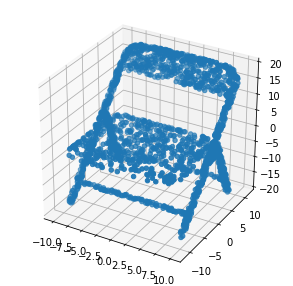

In [6]:
import matplotlib.pyplot as plt

points = mesh.sample(2048)

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(points[:, 0], points[:, 1], points[:, 2])

plt.show()

## メッシュデータの点群化・前準備

メッシュデータの取得とサンプリングを実施する関数を定義

In [7]:
def parse_dataset(num_points=2048):
    train_points = []
    train_labels = []
    test_points = []
    test_labels = []
    class_map = {}
    # README 以外のフォルダ取得
    folders = glob.glob(os.path.join(file_path, "[!README]*"))

    for idx, folder in enumerate(folders):
        print(f"processing class: {os.path.basename(folder)}")
        # フォルダ名取得
        class_map[idx] = folder.split("/")[-1]
        # ファイル取得
        train_files = glob.glob(os.path.join(folder, "train/*"))
        test_files = glob.glob(os.path.join(folder, "test/*"))

        for train_file in train_files:
            # 点群化してリストに追加
            train_points.append(
                trimesh.load(train_file).sample(num_points))
            train_labels.append(idx)

        for test_file in test_files:
            # 点群化してリストに追加
            test_points.append(
                trimesh.load(test_file).sample(num_points))
            test_labels.append(idx)

    return (
        np.array(train_points),
        np.array(test_points),
        np.array(train_labels),
        np.array(test_labels),
        class_map,
    )

np.ndarray でのデータセットを生成

In [8]:
NUM_POINTS = 2048
NUM_CLASSES = 10
BATCH_SIZE = 32

train_points, test_points, train_labels, test_labels, CLASS_MAP = parse_dataset(
    NUM_POINTS
)

print(f"train_points size: {train_points.shape}")
print(f"test_points size: {test_points.shape}")
print(f"train_labels size: {train_labels.shape}")
print(f"test_labels size: {test_labels.shape}")

processing class: bed
processing class: dresser
processing class: desk
processing class: chair
processing class: night_stand
processing class: sofa
processing class: bathtub
processing class: toilet
processing class: table
processing class: monitor
train_points size: (3991, 2048, 3)
test_points size: (908, 2048, 3)
train_labels size: (3991,)
test_labels size: (908,)


学習のために [tf.data.Dataset](https://qiita.com/Suguru_Toyohara/items/820b0dad955ecd91c7f3) を利用

In [9]:
def augment(points, label):
    # ノイズ追加 (PointNet の頑健性チェック)
    points += tf.random.uniform(points.shape, -0.005, 0.005, dtype=tf.float64)
    # 点のシャッフル (MaxPooling の効果チェック)
    points = tf.random.shuffle(points)
    return points, label


train_dataset = tf.data.Dataset.from_tensor_slices((train_points, train_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_points, test_labels))

train_dataset = train_dataset.shuffle(len(train_points)).map(augment).batch(BATCH_SIZE)
test_dataset = test_dataset.shuffle(len(test_points)).batch(BATCH_SIZE)

## PointNet の作成

In [10]:
def conv_bn(x, filters):
    """
    バッチ正則化付き畳込み層
    """
    x = keras.layers.Conv1D(filters, kernel_size=1, padding="valid")(x)
    x = keras.layers.BatchNormalization(momentum=0.0)(x)
    return keras.layers.Activation("relu")(x)


def dense_bn(x, filters):
    """
    バッチ正則化付き全結合層
    """
    x = keras.layers.Dense(filters)(x)
    x = keras.layers.BatchNormalization(momentum=0.0)(x)
    return keras.layers.Activation("relu")(x)

In [11]:
class OrthogonalRegularizer(keras.regularizers.Regularizer):
    def __init__(self, num_features, l2reg=0.001):
        self.num_features = num_features
        # 正則化項の係数
        self.l2reg = l2reg
        self.eye = tf.eye(num_features)

    def __call__(self, x):
        x = tf.reshape(x, (-1, self.num_features, self.num_features))
        # X * X^T
        xxt = tf.tensordot(x, x, axes=(2, 2))
        xxt = tf.reshape(xxt, (-1, self.num_features, self.num_features))
        return tf.reduce_sum(self.l2reg * tf.square(xxt - self.eye))


T-net の作成

In [12]:
def tnet(inputs, num_features):

    # Initalise bias as the indentity matrix
    bias = keras.initializers.Constant(np.eye(num_features).flatten())
    reg = OrthogonalRegularizer(num_features)

    x = conv_bn(inputs, 32)
    x = conv_bn(x, 64)
    x = conv_bn(x, 512)
    x = keras.layers.GlobalMaxPooling1D()(x)
    x = dense_bn(x, 256)
    x = dense_bn(x, 128)
    x = keras.layers.Dense(
        num_features * num_features,
        kernel_initializer="zeros",
        bias_initializer=bias,
        activity_regularizer=reg,
    )(x)
    feat_T = keras.layers.Reshape((num_features, num_features))(x)
    # Apply affine transformation to input features
    return keras.layers.Dot(axes=(2, 1))([inputs, feat_T])

In [13]:
inputs = keras.Input(shape=(NUM_POINTS, 3))

# 3次元空間の正準座標を求めて適用
x = tnet(inputs, 3)
# 特徴量抽出
x = conv_bn(x, 32)
x = conv_bn(x, 32)
# 特徴量空間の正準座標を求めて適用
x = tnet(x, 32)

# 近似的な対称関数を適用 (混合してから対称化)
x = conv_bn(x, 32)
x = conv_bn(x, 64)
x = conv_bn(x, 512)
x = keras.layers.GlobalMaxPooling1D()(x)

# クラス分類
x = dense_bn(x, 256)
x = keras.layers.Dropout(0.3)(x)
x = dense_bn(x, 128)
x = keras.layers.Dropout(0.3)(x)

# 確率出力
outputs = keras.layers.Dense(NUM_CLASSES, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs, name="pointnet")
model.summary()

Model: "pointnet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 2048, 3)]    0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 2048, 32)     128         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 2048, 32)    128         ['conv1d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 2048, 32)     0           ['batch_normalization[0][0

## 学習の実施

In [14]:
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=["sparse_categorical_accuracy"],
)

model.fit(train_dataset, epochs=20, validation_data=test_dataset)

Epoch 1/20
125/125 [==============================] - 36s 166ms/step - loss: 3.4722 - sparse_categorical_accuracy: 0.2886 - val_loss: 17152143022620672.0000 - val_sparse_categorical_accuracy: 0.3183
Epoch 2/20
125/125 [==============================] - 20s 161ms/step - loss: 2.9668 - sparse_categorical_accuracy: 0.4024 - val_loss: 4.9149 - val_sparse_categorical_accuracy: 0.1233
Epoch 3/20
125/125 [==============================] - 20s 162ms/step - loss: 2.7589 - sparse_categorical_accuracy: 0.4896 - val_loss: 6695243734933049442304.0000 - val_sparse_categorical_accuracy: 0.4868
Epoch 4/20
125/125 [==============================] - 20s 163ms/step - loss: 2.5474 - sparse_categorical_accuracy: 0.5560 - val_loss: 4555089842798592.0000 - val_sparse_categorical_accuracy: 0.4604
Epoch 5/20
125/125 [==============================] - 21s 164ms/step - loss: 2.4788 - sparse_categorical_accuracy: 0.5630 - val_loss: 126135040.0000 - val_sparse_categorical_accuracy: 0.4736
Epoch 6/20
125/125 [=====

## 判定

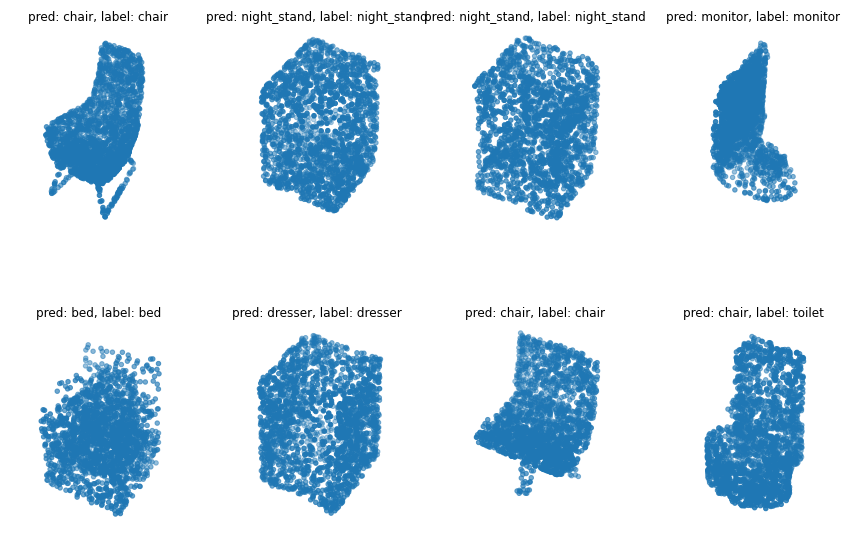

In [15]:
data = test_dataset.take(1)

points, labels = list(data)[0]
points = points[:8, ...]
labels = labels[:8, ...]

# run test data through model
preds = model.predict(points)
preds = tf.math.argmax(preds, -1)

points = points.numpy()

# plot points with predicted class and label
fig = plt.figure(figsize=(15, 10))
for i in range(8):
    ax = fig.add_subplot(2, 4, i + 1, projection="3d")
    ax.scatter(points[i, :, 0], points[i, :, 1], points[i, :, 2])
    ax.set_title(
        "pred: {:}, label: {:}".format(
            CLASS_MAP[preds[i].numpy()], CLASS_MAP[labels.numpy()[i]]
        )
    )
    ax.set_axis_off()
plt.show()